# Тестовое задание

Для выполнения тестового задания требуется разработать модель, которая будет способна различать заголовки реальных и выдуманных новостей.
Для обучения модели используйте данные из файла `train.tsv`. В файле находится таблица, состоящая из двух колонок. 
В колонке title записан заголовок новости. В колонке is_fake содержатся метки: 0 – новость реальная; 1 – новость выдуманная.
Для демонстрации работы модели используйте данные тестового набора из файла `test.tsv`. В нем также есть колонка title, данные которой являются входными для вашей модели.
Вам нужно скопировать файл `test.tsv`, переименовать его в `predictions.tsv` и заполнить колонку is_fake значениями предсказаний вашей модели, аналогично `train.tsv`. 
Изначально колонка заполнена значением 0.

# Критерии оценки
1. Для оценки финального решения будет использоваться метрика F1 score.
2. Чистота кода, оформление и понятность исследования.

# Требования к решению
В качестве решения мы ожидаем zip-архив со всеми *.py и *.ipynb файлами в папке solution и файлом `predictions.tsv` в корне. Формат имени zip-архива: LastName_FirstName.zip (пример Ivanov_Ivan.zip).
Файл `predictions.tsv` должен включать в себя колонку title, содержащую те же данные, что и исходный файл `test.tsv`, а также колонку is_fake, содержащую значения 0 или 1.
Разметка тестового набора данных и включение его в обучение/валидацию запрещены.

#### Импортирую все необходимые библиотеки

In [242]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from time import perf_counter
import warnings
warnings.filterwarnings(action='ignore')

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

#### Для обучения модели буду использовать файл с данными из train.tsv. Прочитаю их и изучу

In [243]:
df_train = pd.read_csv('train.tsv', sep='\t')
df_train.head()

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


In [244]:
df_train.shape

(5758, 2)

In [245]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB


<AxesSubplot:xlabel='is_fake', ylabel='count'>

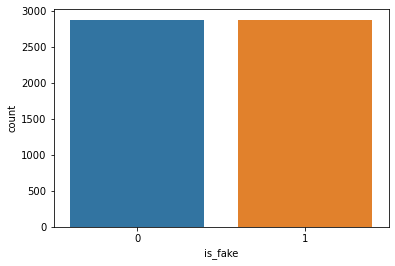

In [246]:
import seaborn as sns
sns.countplot(df_train['is_fake'])

#### По данным видно, что в них должны быть включены только буквы русского алфавита, поэтому очищу их от ненужных символов и приведу все в нижний регистор для того, чтобы впоследствии не было проблем

In [247]:
from nltk.tokenize import RegexpTokenizer

def clean_str(string, reg = RegexpTokenizer(r'[а-я,ё]+')):
    string = string.lower()
    tokens = reg.tokenize(string)
    return " ".join(tokens)

print('Before cleaning:')
df_train['title'][0]

Before cleaning:


'Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы'

In [248]:
print('After cleaning:')
clean_str(df_train['title'][0])

After cleaning:


'москвичу владимиру клутину пришёл счёт за вмешательство в американские выборы'

#### и создам новый столбец с очищенными данными для использования в следующих шагах 

In [249]:
df_train['text_clean'] = df_train['title'].apply(lambda string: clean_str(string))

df_train.head()

,title,is_fake,text_clean
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1,москвичу владимиру клутину пришёл счёт за вмеш...
1,Агент Кокорина назвал езду по встречке житейск...,0,агент кокорина назвал езду по встречке житейск...
2,Госдума рассмотрит возможность введения секрет...,1,госдума рассмотрит возможность введения секрет...
3,ФАС заблокировала поставку скоростных трамваев...,0,фас заблокировала поставку скоростных трамваев...
4,Против Навального завели дело о недоносительст...,1,против навального завели дело о недоносительст...


#### Произведу преобразование набора текстовых документов в матрицу количества токенов

In [250]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(df_train.text_clean)

y = df_train['is_fake']

#### Разделю выборку на train и test (тренировочную и тестовую часть) 

In [251]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1735, random_state=0)

#### Интересно было сравнить модели для задачи классификации по скорости обучения  

In [252]:
models = {
    "Random Forest": {"model":RandomForestClassifier(), "perf":0},
    "Gradient Boosting": {"model":GradientBoostingClassifier(), "perf":0},
    "XGBoost": {"model":XGBClassifier(eval_metric='mlogloss'), "perf":0},
    "MultinomialNB": {"model":MultinomialNB(), "perf":0},
    "Logistic Regr.": {"model":LogisticRegression(), "perf":0},
    "KNN": {"model":KNeighborsClassifier(), "perf":0},
    "Decision Tree": {"model":DecisionTreeClassifier(), "perf":0},
    "SVM (Linear)": {"model":LinearSVC(), "perf":0},
    "SVM (RBF)": {"model":SVC(), "perf":0}
}

for name, model in models.items():
    start = perf_counter()
    model['model'].fit(X_train, y_train)
    duration = perf_counter() - start
    duration = round(duration,2)
    model["perf"] = duration
    print(f"{name:20} обучена за {duration} сек")

Random Forest        обучена за 22.93 сек
Gradient Boosting    обучена за 16.89 сек
XGBoost              обучена за 0.98 сек
MultinomialNB        обучена за 0.01 сек
Logistic Regr.       обучена за 0.49 сек
KNN                  обучена за 0.0 сек
Decision Tree        обучена за 1.86 сек
SVM (Linear)         обучена за 0.05 сек
SVM (RBF)            обучена за 3.52 сек


#### Наглядно можем посмотреть как и с какой метрикой отработала каждая модель 

In [253]:
models_acc = []
for name, model in models.items():
    models_acc.append([name, model["model"].score(X_test, y_test),model["perf"]])

In [254]:
df_acc = pd.DataFrame(models_acc)
df_acc.columns = ['Модель', 'Accuracy без масштабирования', 'Время обучения (сек)']
df_acc.sort_values(by = 'Accuracy без масштабирования', ascending = False, inplace=True)
df_acc.reset_index(drop = True, inplace=True)
df_acc

,Модель,Accuracy без масштабирования,Время обучения (сек)
0,MultinomialNB,0.843,0.01
1,SVM (RBF),0.842,3.52
2,Logistic Regr.,0.836,0.49
3,SVM (Linear),0.833,0.05
4,Random Forest,0.772,22.93
5,XGBoost,0.763,0.98
6,Decision Tree,0.707,1.86
7,Gradient Boosting,0.684,16.89
8,KNN,0.516,0.00


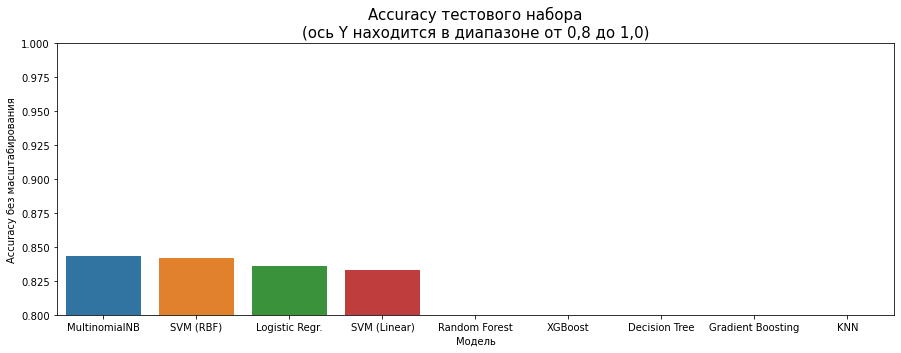

In [255]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'Модель', y = 'Accuracy без масштабирования', data = df_acc)
plt.title('Accuracy тестового набора\n(ось Y находится в диапазоне от 0,8 до 1,0)', fontsize = 15)
plt.ylim(0.8,1)
plt.show()

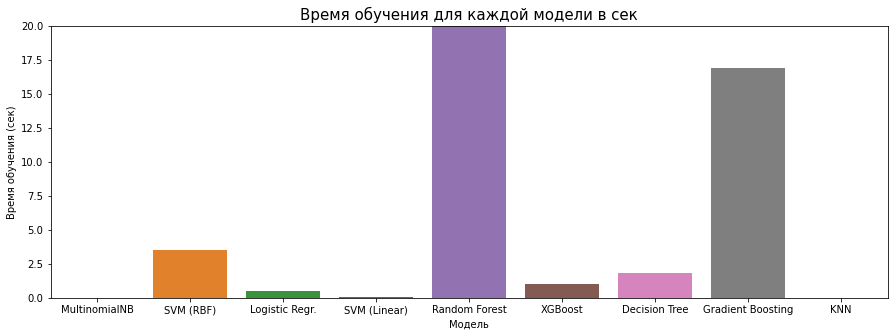

In [256]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'Модель', y = 'Время обучения (сек)', data = df_acc)
plt.title('Время обучения для каждой модели в сек', fontsize = 15)
plt.ylim(0,20)
plt.show()

#### LogisticRegression дает лучший результат на тестовом наборе. Тем не менее, MultinomialNB почти так же хорош, но намного быстрее (0,2 с против 5,1 с). В следующей части мы выберем MultinomialNB и попробуем различные гиперпараметры для его оптимизации

In [257]:
# Надо найти лучший гиперпараметр с помощью GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
parameters = {"alpha": [0.2,1,2,5,10], "fit_prior": [True, False]}

grid = GridSearchCV(MultinomialNB(), param_grid=parameters)
grid.fit(X_train,y_train)

# Создаю DataFrame с лучшими гиперпараметрами
pd.DataFrame(grid.cv_results_)[['params','mean_test_score']]\
                               .sort_values(by="mean_test_score", ascending=False)

,params,mean_test_score
1,"{'alpha': 0.2, 'fit_prior': False}",0.815891
0,"{'alpha': 0.2, 'fit_prior': True}",0.815471
2,"{'alpha': 1, 'fit_prior': True}",0.815261
3,"{'alpha': 1, 'fit_prior': False}",0.814421
4,"{'alpha': 2, 'fit_prior': True}",0.811058
5,"{'alpha': 2, 'fit_prior': False}",0.810638
6,"{'alpha': 5, 'fit_prior': True}",0.790884
7,"{'alpha': 5, 'fit_prior': False}",0.790253
8,"{'alpha': 10, 'fit_prior': True}",0.770706
9,"{'alpha': 10, 'fit_prior': False}",0.766923


In [258]:
# Лучший гиперпараметр
grid.best_params_

{'alpha': 0.2, 'fit_prior': False}

#### Создам модель с лучшими гиперпараметрами 

In [259]:
from sklearn.naive_bayes import MultinomialNB
alpha, fit_prior = grid.best_params_['alpha'], grid.best_params_['fit_prior']
model = MultinomialNB(alpha = alpha)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score
printmd(f'### Accuracy: {round(accuracy_score(y_test,y_pred),3)*100}%\n')

### Accuracy: 83.89999999999999%


#### Выведу мини-отчет по метрикам 

In [260]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       489
           1       0.84      0.84      0.84       511

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000



#### С точностью в почти 84% модель угадывает новость по заголовку (реальная или выдуманная)

#### Для демонстрации работы модели использую файл test.tsv и сохраню его под именем prediction 

In [261]:
prediction = pd.read_csv('test.tsv', sep='\t')

In [262]:
prediction.head()

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,0
1,Ночью под Минском на президентской горе Белара...,0
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,0
3,"Сельская церковь, собравшая рекордно низкое ко...",0
4,Акции Google рухнули после объявления о переза...,0


In [263]:
X_train.shape, X_test.shape, prediction.shape

((4758, 17861), (1000, 17861), (1000, 2))

#### В prediction заполню колонку is_fake значениями предсказаний модели

In [264]:
prediction['is_fake'] = y_pred

#### Сохранение файла с предсказаниями 

In [265]:
prediction.to_csv('predictions.tsv', index=False)